# Estimating COVID-19's $R_t$ in Real-Time

> Original code by Kevin Systrom - April 17 ( *translated into Julia by Hugh Murrell April 2020* )

> Simplification to direct computation of $R_t$ without Bayesian methods by Hugh Murrell May 2020


In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.


### A frequentist approach

Read accompanying article.


In [1]:
using StatsBase, Distributions, Plots, DataFrames, CSV, Dates, HTTP, Impute, DSP;
# some model parameters that will be used throughout this notebook
IFP = 7   # infectious period in days
GAMMA = 1/IFP  # recovery rate
SMOOTHING_PASSES = 3 # number of times to apply moving average filter to case data
INF_CUTOFF = 0.0 # for detecting instability after pandemic has run its course
ONSET_DELAY = 4  # default onset delayin days, might get changed later
println("IFP=",IFP," GAMMA=",GAMMA," SMOOTHING_PASSES=",
    SMOOTHING_PASSES," INF_CUTOFF=",INF_CUTOFF," ONSET_DELAY=",ONSET_DELAY)

IFP=7 GAMMA=0.14285714285714285 SMOOTHING_PASSES=3 INF_CUTOFF=0.0 ONSET_DELAY=4


#### helper functions for applying onset-reporting delay

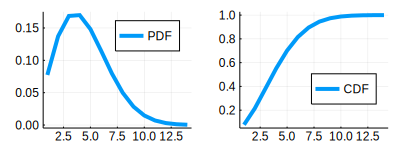

In [2]:
adj_range = collect(1:1:14)
p_delay = [pdf.(Weibull(2, 5),t) for t in adj_range]
p_delay = p_delay ./ sum(p_delay)
fig_weibull_pdf = plot(adj_range, p_delay, lw=4, label="PDF")
fig_weibull_cdf= plot(adj_range, cumsum(p_delay), lw=4, label="CDF",legend=:bottomright)
fig_weibull = plot(fig_weibull_pdf,fig_weibull_cdf,layout=(1,2),size=(400,150))
savefig("plots/fig_weibull")
fig_weibull

In [3]:
ONSET_DELAY = findmax(p_delay)[2]

4

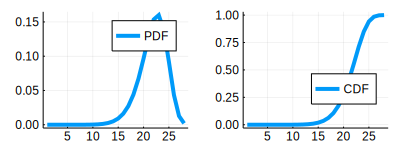

In [4]:
adj_range = collect(1:1:28)
d_delay = [pdf.(Weibull(10, 23),t) for t in adj_range]
d_delay = d_delay ./ sum(d_delay)
fig_weibull_death_pdf = plot(adj_range, d_delay, lw=4, label="PDF")
fig_weibull_death_cdf= plot(adj_range, cumsum(d_delay), lw=4, label="CDF",legend=:bottomright)
fig_weibull_death = plot(fig_weibull_death_pdf,fig_weibull_death_cdf,layout=(1,2),size=(400,150))
savefig("plots/fig_weibull_death")
fig_weibull_death

In [5]:
DEATH_ONSET_DELAY = findmax(d_delay)[2]

23

In [6]:
function ext_pad(seq,n)
    s = log.(seq)
    s_ext = s[end-n+1:end].+(s[end]-s[end-n])
    return exp.(vcat(s,s_ext))
end

ext_pad (generic function with 1 method)

In [7]:
function estimate_onset(seq, p_delay)
    nc = ext_pad(seq,length(p_delay))
    return reverse(conv(reverse(nc),p_delay))[length(p_delay):end-length(p_delay)]
end

estimate_onset (generic function with 1 method)

In [8]:
function adjust_onset(onset, p_delay)  # not needed anymore
    return onset
    c_delay = cumsum(p_delay)
    extras = length(onset) - length(c_delay)
    if (extras > 0)
        cd = vcat(c_delay,ones(extras))
    end
    adjusted = onset ./ reverse(cd)
    return adjusted[1:end]
end

adjust_onset (generic function with 1 method)

#### helper functions for smoothing time series and stripping leading zero case counts

In [9]:
function moving_average(inf)
    vs = inf
    if length(vs) > 1
        ret = 
            vcat((vs[1]+2*vs[1])/3,
                   [sum(@view vs[i:(i+2)])/3 for i in 1:(length(vs)-(2))],
                    (2*vs[length(vs)]+vs[length(vs)])/3)
    else
        ret = vs
    end
    return ret
    return Int64.(round.(ret))
end

moving_average (generic function with 1 method)

In [10]:
function smooth_seq(seq)
    ret = copy(seq)
    for i in 1:SMOOTHING_PASSES
        ret = moving_average(ret)
    end
    return ret
end

smooth_seq (generic function with 1 method)

In [11]:
function exponential_smoothing(seq; alpha=0.5)
    ss = copy(seq)
    for i in 2:length(ss)
        ss[i] = alpha * seq[i] + (1 - alpha)*ss[i-1]
    end
    return ss
end

exponential_smoothing (generic function with 1 method)

In [12]:
function compute_infectives(new_cases) 
    onset = estimate_onset(new_cases,p_delay)
    adj_onset = adjust_onset(onset,p_delay)
    if length(adj_onset) >= IFP
       infects = [sum(adj_onset[i-IFP+1:i])
                        for i in IFP:length(adj_onset) ] 
    else
        infects = []
    end
    return infects
end

compute_infectives (generic function with 1 method)

In [13]:
function strip_leading_zeros(vec)
    nz = copy(vec)
    ind = 1
    while (ind <= length(nz) && nz[ind]<=0)
        ind+=1
    end
    nz = copy(nz[ind:end,:])
    return(nz)
end

strip_leading_zeros (generic function with 1 method)

## South Africa Rt estimates, with confidence intervals, using OWID data

In [14]:
url="https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/full_data.csv"
# full_data = CSV.read(IOBuffer(HTTP.get(url).body))
full_data = readtable(IOBuffer(HTTP.get(url).body), 
    eltypes = [String, String, Float64, Float64, Float64, Float64])
full_data = full_data[full_data[:,:location].=="South Africa",:]
date_format = DateFormat("yyyy-mm-dd")
full_data[!,:date] = Date.(full_data[:,:date],date_format)
println("ZA table read, size = ",size(full_data))
println("ZA latest counts on ",maximum(full_data[:,:date]))
printstyled(full_data)

ZA table read, size = (102, 6)
ZA latest counts on 2020-06-17
102×6 DataFrame
│ Row │ date       │ location     │ new_cases │ new_deaths │ total_cases │ total_deaths │
│     │ Date       │ String⍰      │ Float64⍰  │ Float64⍰   │ Float64⍰    │ Float64⍰     │
├─────┼────────────┼──────────────┼───────────┼────────────┼─────────────┼──────────────┤
│ 1   │ 2020-03-06 │ South Africa │ 1.0       │ 0.0        │ 1.0         │ 0.0          │
│ 2   │ 2020-03-08 │ South Africa │ 1.0       │ 0.0        │ 2.0         │ 0.0          │
│ 3   │ 2020-03-09 │ South Africa │ 1.0       │ 0.0        │ 3.0         │ 0.0          │
│ 4   │ 2020-03-10 │ South Africa │ 4.0       │ 0.0        │ 7.0         │ 0.0          │
│ 5   │ 2020-03-12 │ South Africa │ 6.0       │ 0.0        │ 13.0        │ 0.0          │
│ 6   │ 2020-03-13 │ South Africa │ 4.0       │ 0.0        │ 17.0        │ 0.0          │
│ 7   │ 2020-03-14 │ South Africa │ 7.0       │ 0.0        │ 24.0        │ 0.0          │
│ 8   │ 2020-03-15 │ S

In [15]:
# output_url = "../../HughMurrell.github.io/CoVmodel/RtLiveZA/"
# url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
# data = CSV.read(IOBuffer(HTTP.get(url).body),
#             types=[String, String, Float64, Float64, Float64, Float64, Float64, 
#                    Float64, Float64, Float64, Float64, Float64, Float64, String])
# date_format = DateFormat("dd-mm-yyyy")
# data[!,:date] = Date.(data[:,:date],date_format)
# data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
data = full_data
allowmissing!(data)
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,[ d, "South Africa", missing, missing, missing, missing ])
    end
end
sort!(data)
data_date = maximum(data[:,:date])
# regions=names(data)[2:end]
# region = :total
fig_cases = plot(legend=:topleft,ylabel="new cases",
    title="cases onset adjustment and nowcasting\n for South Africa from $data_date data")
fig_deaths = plot(legend=:topleft,ylabel="new deaths",
    title="deaths onset adjustment\n from $data_date data")
fig_rts = plot(legend=:topleft, ylimits = [-1,4],
    title="finite difference Rt estimates from onset adjusted infectives\n for South Africa from $data_date data")

# compute infectives from cases
cases = Impute.interp(data[:,:total_cases])   # can impute on total cases (not on new-cases)
println("no of cases data points = ",length(cases))
cases = smooth_seq(cases)
infectives = [ cases[i]-cases[i-IFP] for i in IFP+2:length(cases) ]

# now do the same with deaths
deaths = Impute.interp(data[:,:total_deaths])   # can impute on totals
println("no of death data points = ",length(deaths))
deaths = smooth_seq(deaths)
death_infectives = [ deaths[i]-deaths[i-IFP] for i in IFP+2:length(deaths) ]
death_infectives = strip_leading_zeros(death_infectives)

onset_cases = estimate_onset(diff(cases),p_delay)
adj_onset_cases = adjust_onset(onset_cases,p_delay)
plot!(fig_cases, [ diff(cases), onset_cases ], 
    labels=[ "new cases" "onset nowcast" ],lw=6)
savefig(fig_cases,"plots/RtLiveZAonsetAdjCases")

adj_cases = cumsum(adj_onset_cases)
adj_infectives = [ adj_cases[i]-adj_cases[i-IFP] for i in (IFP+1):length(adj_cases) ]
# drop the first IFP and the last ONSET_DELAY data points because onset alg looses them
# dates = data[IFP:end-ONSET_DELAY-2,:date]  
dates = data[IFP+ONSET_DELAY+2:end,:date]
est_date = maximum(dates)
max_inf = maximum(infectives)
println("processing ... max(inf) = ",max_inf)
for i in 1:SMOOTHING_PASSES
    infectives = moving_average(infectives)
end
rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/infectives[i]) 
                            for i in 1:length(infectives)-1]
# drop the first few data points to shift the crude est back in time
rt_est = rt_est[ONSET_DELAY:end]  
infectives = infectives[ONSET_DELAY+1:end]  
adj_rt_est = [ 1 + IFP * ((adj_infectives[i+1]-adj_infectives[i])/adj_infectives[i]) 
                            for i in 1:length(adj_infectives)-1]
# adj_rt_est = adj_rt_est[1:end-ONSET_DELAY+1]
adj_rt_est = adj_rt_est[ONSET_DELAY:end]
# adj_infectives = adj_infectives[1:end-ONSET_DELAY]  
adj_infectives = adj_infectives[ONSET_DELAY+1:end]  
# exp_smooth_rts = exponential_smoothing(adj_rt_est,alpha=0.5)

# do the same for deaths
onset_deaths = estimate_onset(diff(deaths),d_delay)
adj_onset_deaths = adjust_onset(onset_deaths,d_delay)
plot!(fig_deaths, [ diff(deaths), onset_deaths ], 
    labels=[ "new deaths" "onset nowcast" ],lw=6)
savefig(fig_deaths,"plots/RtLiveZAonsetAdjDeaths")
adj_deaths = cumsum(adj_onset_deaths)
adj_death_infectives = [ adj_deaths[i]-adj_deaths[i-IFP] for i in (IFP+1):length(adj_deaths) ]
adj_death_infectives = adj_death_infectives[DEATH_ONSET_DELAY+1:end] 


est_score = round(rt_est[end],digits=2)
adj_score = round(adj_rt_est[end],digits=2)
# exp_score = round(exp_smooth_rts[end],digits=2)
count = Int64(round(infectives[end],digits=0))
println(length(dates))
println(length(rt_est))
println(length(adj_rt_est))
println(length(infectives))
println(length(adj_infectives))
#plot!(fig_rts, dates, rt_est, lw=6,m=:circle,label="left shifted Rt $est_score")
plot!(fig_rts, dates, adj_rt_est, lw=6,m=:circle,label="Rt estimates, latest=$adj_score")
p = twinx(fig_rts)
plot!(p, dates, adj_infectives,lw=6,m=:circle,color=2,
    legend=:topright,label="onset adjusted infectives")
savefig(fig_rts,"plots/fig_rt_inf_za")

no of cases data points = 104
no of death data points = 104
processing ... max(inf) = 23104.51851851852
92
92
92
92
92


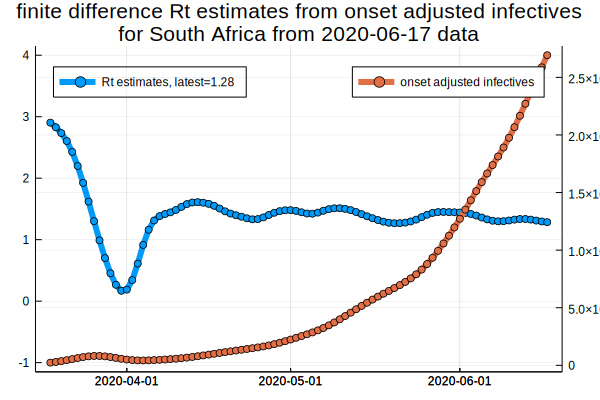

In [16]:
fig_rts

In [17]:
function get_posteriors(inf, sigma=0.013)
    sr = inf # Int64.(floor.(inf))
    # (1) Calculate Lambda
    RT_MAX = 12
    RTL = RT_MAX*100+1
    rt_range = collect(range(0, RT_MAX, length=RTL))
    # GAMMA = 1/IFP   # done previously
    lambdas = [ sr[i-1] .* exp.(GAMMA .* (rt_range .- 1)) for i in 2:length(sr)]
    lambdas = hcat(lambdas...)

    # (2) Calculate each day's likelihood
    pDist = [[Poisson(lam) for lam in lambdas[:,j]] for j in 1:size(lambdas)[2] ]
    lks = [ [pdf.(pDist[j-1][i],Int64(floor(sr[j]))) for i in 1:length(pDist[j-1])] for j in 2:length(sr)]
    lks = hcat(lks...)
    likelihoods = lks ./ sum(lks, dims=1)
    
    #=
    # (3) Create the Gaussian Matrix
    nDist = [ Normal(rt,sigma) for rt in rt_range ]
    process_matrix = [ [pdf.(nDist[j],rt_range[i]) for i in 1:length(rt_range)] 
        for j in 1:length(rt_range)]
    process_matrix = hcat(process_matrix...)
    
    # (3a) Normalize all rows to sum to 1
    process_matrix = process_matrix ./ sum(process_matrix, dims=2)
    
    # process_matrix = I   # if you want current prior = previous posterior
    =#
    
    gw = DSP.Windows.gaussian(RTL,sigma)
    gw = gw ./ sum(gw)
    
    # (4) Calculate the initial prior
    guess0 = 2+log(sr[2]/sr[1])/GAMMA
    if guess0 < 1 
        guess0 = 1
    end
    # println(guess0)
    prior0 = [ pdf.(Gamma(guess0),rt) for rt in rt_range ]
    prior0 = prior0 ./ sum(prior0)
    
    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = DataFrame( [ Real for i in 1:length(sr) ], 
        [ Symbol.("D$i") for i in 1:length(sr) ], length(rt_range) )
    days = names(posteriors)
    # posteriors[:,:rts] = rt_range
    posteriors[:,:D1] = prior0
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0
    
       # (5) Iteratively apply Bayes' rule
    nd = length(days)
    # println("nd=$nd")
    for (previous_day, current_day) in zip(1:nd-1, 2:nd)

        #(5a) Calculate the new prior
        # current_prior =   process_matrix * posteriors[:,Symbol("D$previous_day")] # 
        current_prior = convert.(Float64,posteriors[:,Symbol("D$previous_day")])
        current_prior = conv(current_prior, gw)
        start=1+div(RTL-1,2)
        stop=length(current_prior)-div(RTL-1,2)
        current_prior = current_prior[start:stop]
        # current_prior = current_prior/sum(current_prior)       
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[:,current_day-1] .* current_prior
        # numerator = exp.( (1-sigma) .* log.(likelihoods[:,current_day-1]) .+ 
        #     sigma .* log.(posteriors[:,Symbol("D$previous_day")]) )
        # numerator = likelihoods[:,current_day-1] .* 
        #     posteriors[:,Symbol("D$previous_day")].^(sigma)
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[:,Symbol("D$current_day")] = numerator./denominator
        
        # Add to the running sum of log likelihoods
        if denominator > 0 
            log_likelihood += log(denominator)
        end
        
    end
    
    return (posteriors, rt_range, log_likelihood)
    
end

get_posteriors (generic function with 2 methods)

  7.371790 seconds (25.04 M allocations: 2.595 GiB, 9.42% gc time)


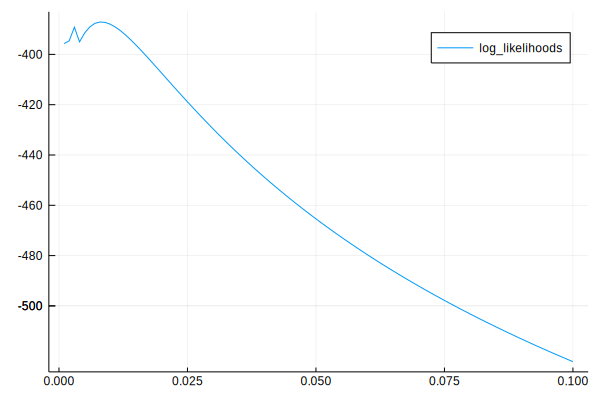

In [18]:
trials = collect(0.001:0.001:0.1)
@time lls = [get_posteriors(adj_infectives, sigma)[3] for sigma in trials]
plot(trials,lls,label="log_likelihoods")

  0.073389 seconds (203.14 k allocations: 24.171 MiB, 10.21% gc time)
ll=-396.31575665100803
(1201, 92)

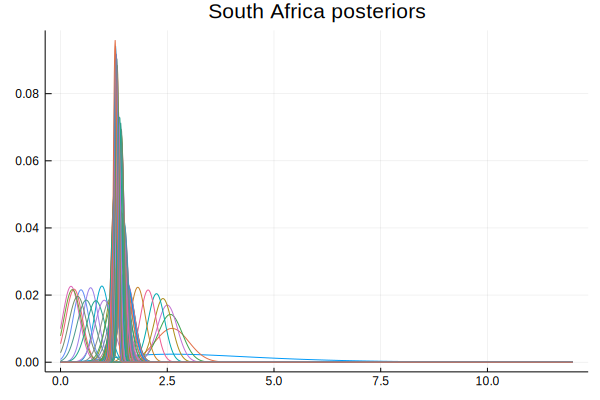

In [19]:
@time (posteriors, rts, log_likelihood) = get_posteriors(adj_infectives, 0.015)
println("ll=",log_likelihood)
print(size(posteriors))
plot(rts,Array(posteriors),label=nothing,title="South Africa posteriors")

In [20]:
function highest_density_interval(pmf, p=.9)
    fb = findmax(pmf,dims=1)[2][1]
    cs = cumsum(pmf, dims=1)
    first = [1, length(cs)]
    best = first
    for (i, value) in enumerate(cs)
        for (j, high_value) in enumerate(cs[i+1:end])
            if ( (high_value-value > p) && (j<best[2]-best[1]) )
                best = [i, i+j]
                break
            end
        end
    end
    if (best == first) 
        # println(" invoking fallback ... ", fb )
        best = [fb, fb]
    end
    return best
end      

highest_density_interval (generic function with 2 methods)

92
92
73
73
92


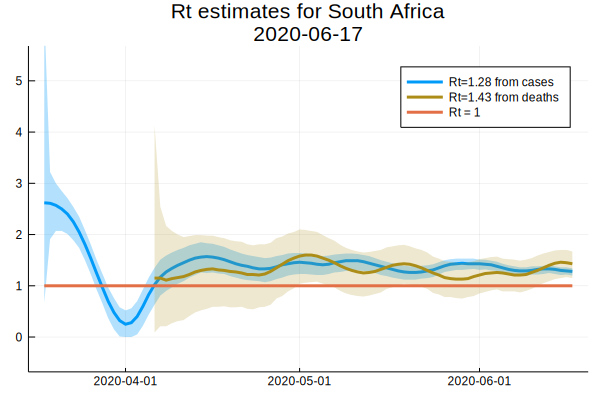

In [21]:
(posteriors, rts, log_likelihood) = get_posteriors(adj_infectives, 0.015)
mlrt_values = rts[map(x->x[1],findmax(Array(posteriors),dims=1)[2])[1,:]]
println(length(mlrt_values))
println(length(dates))
inds = [ highest_density_interval(posteriors[:,k]) for k in 1:size(posteriors)[2] ] 
low_high = [rts[inds[k]] for k in 1:length(inds)]
lows = map(x->x[1],low_high)
highs = map(x->x[2],low_high)

# now do the same with deaths
# deaths = Impute.interp(data[:,:total_deaths])   # can impute on totals
# println("no of death data points = ",length(deaths))
# death_infectives = [ deaths[i]-deaths[i-IFP] for i in IFP+2:length(deaths) ]
# death_infectives = strip_leading_zeros(death_infectives)
# for i in 1:SMOOTHING_PASSES
#    death_infectives = moving_average(death_infectives)
# end
println(length(adj_death_infectives))
(posteriors, rts, log_likelihood) = get_posteriors(adj_death_infectives, 0.015)
rt_deaths = rts[map(x->x[1],findmax(Array(posteriors),dims=1)[2])[1,:]]
println(length(rt_deaths))
rt_deaths = vcat([missing for j in 1:length(dates)-length(rt_deaths)], rt_deaths)
println(length(rt_deaths))
inds = [ highest_density_interval(posteriors[:,k]) for k in 1:size(posteriors)[2] ] 
low_high = [rts[inds[k]] for k in 1:length(inds)]
death_lows = map(x->x[1],low_high)
death_highs = map(x->x[2],low_high)
death_lows = vcat([missing for j in 1:length(dates)-length(death_lows)], death_lows)
death_highs = vcat([missing for j in 1:length(dates)-length(death_highs)], death_highs)

df = DataFrame(date = dates, location = repeat(["South Africa"],length(dates)), 
        mlrt = mlrt_values, low = lows, high = highs, 
        death_rt = rt_deaths, death_low = death_lows, death_high = death_highs)
# df = df[2:end,:]
mlrt_score = round(sum(mlrt_values[end:end]),digits=2)
death_rt_score = round(sum(rt_deaths[end:end]),digits=2)
fig = plot(df[:,:date], df[:,:mlrt],
        ribbon = (df[:,:mlrt]-df[:,:low],df[:,:high]-df[:,:mlrt]), # m=:circle,
        fillalpha=0.3, lw = 3, label = "Rt=$mlrt_score from cases",
        ylimits=[-0.5,5.5], # legendtitle="$est_date",
        title= "Rt estimates for South Africa\n $est_date")
# plot!(fig, dates, adj_rt_est, lw=2, label="estimate $adj_score",
#         color=3)
plot!(df[:,:date], df[:,:death_rt],
      ribbon = (df[:,:death_rt]-df[:,:death_low],df[:,:death_high]-df[:,:death_rt]), 
      fillalpha=0.2, lw=3, color=5, label="Rt=$death_rt_score from deaths")
plot!(df[:,:date], ones(size(df)[1]),lw=3,color=2, label="Rt = 1")
savefig(fig,"plots/RtLivePlusConfIntZA")
fig

In [22]:
CSV.write("plots/national_rts.csv",df)

"plots/national_rts.csv"

## South African provincial Rt estimates using data from the DSFSI

In [23]:
output_url = "./"
url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
data = CSV.read(IOBuffer(HTTP.get(url).body),
            types=[String, String, Float64, Float64, Float64, Float64, Float64, 
                    Float64, Float64, Float64, Float64, Float64, Float64, String])
date_format = DateFormat("dd-mm-yyyy")
data[!,:date] = Date.(data[:,:date],date_format)
data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,vcat(d, [missing for i in 1:size(data)[2]-2], 0))
    end
end
sort!(data)
data_date = data[end,:date]
println(data_date)
regions=names(data)[2:end]
prov_df = DataFrame(date=Date[], location=String[], infectives=Float64[], 
                        mlrt=Float64[], low=Float64[], high=Float64[])
for region in regions
    println(region)
    cases = Impute.interp(data[:,region])   # can impute on total cases (not on new-cases)
    cases = smooth_seq(cases)
    onset_cases = estimate_onset(abs.(diff(cases)),p_delay)
    fig_cases = plot(legend=:topleft,ylabel="new cases",
        title="onset adjustment and nowcasting\n for $region from $data_date data")
    plot!(fig_cases, [ diff(cases), onset_cases ], 
        labels=[ "new cases" "onset nowcast" ],lw=6)
    savefig(fig_cases,"plots/ProvOnsetCases$region")
    onset_cases = cumsum(onset_cases)
    infectives = [ onset_cases[i]-onset_cases[i-IFP] for i in IFP+1:length(onset_cases) ]
    (posteriors, rts, log_likelihood) = get_posteriors(infectives, 0.015)
    mlrt_values = rts[map(x->x[1],findmax(Array(posteriors),dims=1)[2])[1,:]]
    inds = [ highest_density_interval(posteriors[:,k]) for k in 1:size(posteriors)[2] ] 
    low_high = [rts[inds[k]] for k in 1:length(inds)]
    lows = map(x->x[1],low_high)
    highs = map(x->x[2],low_high)
    dates = data[IFP+2:end,:date]
    println("infectives=",length(infectives)," mlrt=",length(mlrt_values)," dates=",length(dates))
    mlrt_score = round(sum(mlrt_values[end:end]),digits=2)
    df = DataFrame(date=dates, location=repeat(["$region"],length(dates)), infectives=round.(infectives,digits=1), 
                        mlrt=mlrt_values, low=lows, high=highs)
    fig_rt_inf = plot(df[:,:date], df[:,:mlrt],
        ribbon = (df[:,:mlrt]-df[:,:low],df[:,:high]-df[:,:mlrt]), # m=:circle,
        fillalpha=0.3, lw = 6, label = "Rt = $mlrt_score at $data_date",
        ylimits=[-0.5,5.5], legend=:topleft,
        title= "Rt estimates for $region\n $data_date")
    p = twinx(fig_rt_inf)
    plot!(p, dates, infectives,lw=6,color=2,
        legend=:topright,label="onset adjusted infectives")
    savefig(fig_rt_inf,"plots/ProvRtInf$region")
    prov_df=vcat(prov_df,df)
end

2020-06-17
EC
infectives=97 mlrt=97 dates=97
FS
infectives=97 mlrt=97 dates=97
GP
infectives=97 mlrt=97 dates=97
KZN
infectives=97 mlrt=97 dates=97
LP
infectives=97 mlrt=97 dates=97
MP
infectives=97 mlrt=97 dates=97
NC
infectives=97 mlrt=97 dates=97
NW
infectives=97 mlrt=97 dates=97
WC
infectives=97 mlrt=97 dates=97
total
infectives=97 mlrt=97 dates=97


In [24]:
CSV.write("plots/provincial_rts.csv",prov_df)

"plots/provincial_rts.csv"